In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import sys,os,time
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import rasterio
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from sklearn.feature_extraction.image import extract_patches_2d
import cProfile

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
p = pd.read_csv("big_lc_paths.csv", header=None)
paths = p[0].tolist()
palette = np.array([[0,0,0],[0,153,51],[0,102,255],[153,102,51],[255,153,0],[255,255,0],[204,102,153]])
palette_torch = torch.from_numpy(palette[1:,:]).float().to(device)

#efficiently calculate cumulative sums
def cum_sum(arr, s):
    cumsum = torch.cumsum(torch.cumsum(arr,dim=2),dim=3)
    cumsum = F.pad(cumsum,(1,0,1,0),'constant',0)
    return cumsum[:,:,:-s,:-s]-cumsum[:,:,s:,:-s]-cumsum[:,:,:-s,s:]+cumsum[:,:,s:,s:]

#create a 10 channel structure from tile t at (x,y) of size size
def t_load(t,x,y,size):
    naip_tile = rasterio.open('/mnt/blobfuse/esri-naip/'+paths[t][:-7]+'.mrf','r')
    naip = naip_tile.read().astype(float)/255.
    naip_tile.close()
    lc_tile = rasterio.open('/mnt/blobfuse/resampled-lc/'+paths[t],'r')
    lc = np.squeeze(lc_tile.read())
    lc_tile.close()
    lc[lc==1]=10
    lc[lc==2]=1
    lc[lc==10]=2
    lc[lc==4]=0
    lc[lc==15]=4
    temp = naip[:,x:x+size,y:y+size]
    t = np.zeros((10,temp.shape[1],temp.shape[2]),dtype=float)
    t[:4,:,:] = temp
    query_lc = lc[x:x+size,y:y+size]
    for i in range(6):
        t[4+i,:,:] = (query_lc==(i+1))
    t = np.expand_dims(t,axis=0)
    return torch.from_numpy(t).float().to(device)

#load an entire tile
def t_load_full(t):
    return t_load(t,0,0,10000)

#display 10 channel structure
def disp_10(t):
    fig=plt.figure(figsize=(14,10))
    fig.add_subplot(121)
    plt.axis('off')
    plt.imshow(t[0,:3,:,:].permute(1,2,0))
    fig.add_subplot(122)
    plt.axis('off')
    plt.imshow(palette_torch[get_labels(t)].int())
    plt.show()
    plt.close()
    
def get_labels(t):
    return torch.argmax(t[0,4:,:,:],dim=0)

#learns N x N epitome from T, K x K random patches drawn from input image x.
#Applies NIT iterations of the E-M algorithm at scales sc; T*sc^2 patches are sampled.
#no longer accepts initializations of e or ev
#e,ev = initial epitome mean and variance. The mean is initialized
#to the uniform image with some small noise, and the variance is initialized to 1
#p holds an array of probabilities of using each part of the epitome

def epitome_noe(x,K,N,T,NIT,sc):
    numDim = x.shape[1]
    return epitome(x,K,N,T,NIT,sc,torch.zeros((1,numDim,N,N)).to(device))

def epitome(x,K,N,T,NIT,sc,einit):
    xFIN = x
    x = F.interpolate(x,scale_factor=sc[0])
    _, numDim, SY, SX = x.shape
    TFIN = T
    T = int(np.ceil(T*sc[0]**2))
    NFIN = N
    N = int(np.ceil(sc[0]*N))
    e = torch.zeros((1,numDim,N,N)).to(device)#mean of image plus noise
    ev = torch.ones((1,numDim,N,N)).to(device)/50
    for i in range(numDim):
        e[:,i,:,:] = x[0,i,:,:].std()*torch.randn(N,N).to(device)/100+x[0,i,:,:].mean()
    p = torch.ones((N,N)).to(device)/N**2
    MINP = 1e-8#1e-8 is acceptable
    MINV = 5e-2#1e-6
    #etr = torch.zeros((NIT+1,1,numDim,NFIN,NFIN))
    #etr[0,:,:,:,:] = F.interpolate(e,[NFIN,NFIN])
    #perform NIT iterations of EM algorithm
    for sci in range(len(sc)):
        if sci != 0:
            N = int(np.ceil(sc[sci]*NFIN))
            e = F.interpolate(e,[N,N]).to(device)
            ev = F.interpolate(ev,[N,N]).to(device)
            p = torch.ones((N,N)).to(device)/N**2
            x = F.interpolate(xFIN,scale_factor=sc[sci]).to(device)
            T = int(np.ceil(sc[sci]**2*TFIN))
        sumP = torch.zeros((N,N),dtype=torch.float).to(device)
        sumPy = torch.zeros((numDim,N,N),dtype=torch.float).to(device)
        sumPy2 = torch.zeros((numDim,N,N),dtype=torch.float).to(device)
        ewrap = torch.zeros((numDim,N+K-1,N+K-1),dtype=torch.float).to(device)
        evwrap = torch.zeros((numDim,N+K-1,N+K-1),dtype=torch.float).to(device)
        SY = x.shape[2]
        SX = x.shape[3]
        patchnum = min(T,(SY-K)**2)
        ytemp = np.rollaxis(extract_patches_2d(torch.squeeze(x).permute(1,2,0),(K,K),max_patches=patchnum),3,1)
        y = torch.from_numpy(ytemp).float().to(device)
        for nit in range(NIT):
            ewrap[:,:N,:N] = e;
            ewrap[:,N:,:] = ewrap[:,:K-1,:]
            ewrap[:,:,N:] = ewrap[:,:,:K-1]
            evwrap[:,:N,:N] = ev
            evwrap[:,N:,:] = evwrap[:,:K-1,:]
            evwrap[:,:,N:] = evwrap[:,:,:K-1]
            # E STEP
            sumP[:,:] = 0
            sumPy[:,:,:] = 0
            sumPy2[:,:,:] = 0
            yt = torch.flip(y,[2,3])
            tmp3 = torch.sum(torch.squeeze(cum_sum(torch.unsqueeze(ewrap**2/evwrap,0),K)),dim=0)
            tmp4 = torch.sum(torch.squeeze(cum_sum(torch.unsqueeze(torch.log(evwrap),0),K)),dim=0)
            idxp = 0
            #batch size is independent of input size
            batch_size = 8000
            while idxp*batch_size<patchnum:
                ytc = yt[idxp*batch_size:idxp*batch_size+batch_size,:,:,:]
                tmp1full = torch.squeeze(F.conv2d(torch.unsqueeze(1/evwrap,0),ytc**2))
                tmp2full = torch.squeeze(F.conv2d(torch.unsqueeze(ewrap/evwrap,0),ytc))
                for tx in range(tmp1full.shape[0]):
                    lP = torch.log(p)-.5*(tmp4+tmp1full[tx,:,:]-2*tmp2full[tx,:,:]+tmp3)
                    P = torch.exp(lP-torch.max(lP))+MINP
                    P /= torch.sum(P)
                    tmp = F.pad(P.view(1,1,N,N),(K-1,K-1,K-1,K-1),'constant',0).to(device)
                    tmp_sumP = torch.squeeze(cum_sum(tmp,K))
                    tmp_sumP[:,:K-1] += tmp_sumP[:,N:]
                    tmp_sumP[:K-1,:] += tmp_sumP[N:,:]
                    sumP += tmp_sumP[:N,:N]
                    yctmp = torch.unsqueeze(y[batch_size*idxp+tx,:,:,:],1)
                    tmp_sumPy = torch.squeeze(F.conv2d(tmp,yctmp))
                    tmp_sumPy[:,:,:K-1] += tmp_sumPy[:,:,N:]
                    tmp_sumPy[:,:K-1,:] += tmp_sumPy[:,N:,:]
                    sumPy += tmp_sumPy[:,:N,:N]
                    tmp_sumPy2 = torch.squeeze(F.conv2d(tmp,yctmp**2))
                    tmp_sumPy2[:,:,:K-1] += tmp_sumPy2[:,:,N:]
                    tmp_sumPy2[:,:K-1,:] += tmp_sumPy2[:,N:,:]
                    sumPy2 += tmp_sumPy2[:,:N,:N]
                torch.cuda.empty_cache()
                idxp += 1
            #M STEP
            #p = sumP/torch.sum(sumP)#commented out
            e[0,:,:,:] = sumPy/sumP
            if nit>10 or sci>0:
                ev[0,:,:,:] = sumPy2/sumP - 2*e[0,:,:,:]*sumPy/sumP+e[0,:,:,:]**2
            ev = torch.clamp(ev,min=MINV)
            etemp = F.interpolate(e,[NFIN,NFIN])
            #etr[nit+1,:,:,:] = etemp
            fig=plt.figure(figsize=(20,7))
            fig.add_subplot(131)
            plt.axis('off')
            plt.imshow(etemp[0,:3,:,:].permute(1,2,0))
            plt.title('%i^2 epitome, iteration %i' % (N,nit+1))
            e_colors = e[0,4:,:,:].permute(1,2,0).view(-1,6)
            fig.add_subplot(132)
            plt.axis('off')
            plt.imshow(torch.matmul(e_colors,palette_torch).view(N,N,3)/256)
            plt.title('labeled epitome')
            fig.add_subplot(133)
            plt.axis('off')
            plt.imshow(torch.sum(torch.squeeze(ev),dim=0),cmap='hot',interpolation='nearest')
            plt.title('variances')
            plt.show()
            plt.close()   
    return e,ev,p#,etr

#call reconstruct over multiple epitomes
#here, e,ev, and emod should be lists of e and ev for multiple epitomes

def reconstructplural(x,K,e,ev,emod,SPC):
    _,NoCh1,SY,SX = x.shape
    NoCh2 = emod[0].shape[0]
    N = e[0].shape[2]
    nume = len(e)
    elist = torch.zeros((nume,NoCh1,N+K-1,N+K-1)).to(device)
    evlist = torch.zeros((nume,NoCh1,N+K-1,N+K-1)).to(device)
    emodlist = torch.zeros((nume,NoCh2,N+K-1,N+K-1)).to(device)
    tmp3list = torch.zeros((nume,N,N)).to(device)
    tmp4list = torch.zeros((nume,N,N)).to(device)
    for i in range(nume):
        elist[i,:,:N,:N] = e[i]
        elist[i,:,N:,:] = elist[i,:,:K-1,:]
        elist[i,:,:,N:] = elist[i,:,:,:K-1]
        evlist[i,:,:N,:N] = ev[i]
        evlist[i,:,N:,:] = evlist[i,:,:K-1,:]
        evlist[i,:,:,N:] = evlist[i,:,:,:K-1]
        tmp3list[i] = torch.sum(torch.squeeze(cum_sum(torch.unsqueeze(elist[i]**2/evlist[i],0),K)),dim=0)
        tmp4list[i] = torch.sum(torch.squeeze(cum_sum(torch.unsqueeze(torch.log(evlist[i]),0),K)),dim=0)
        emodlist[i,:,:N,:N] = emod[i]
        emodlist[i,:,N:,:] = emodlist[i,:,:K-1,:]
        emodlist[i,:,:,N:] = emodlist[i,:,:,:K-1]
    z = torch.zeros((NoCh2,SY,SX)).to(device)
    cnt = torch.zeros((SY,SX)).to(device)
    ixt = 0
    iyt = 0
    lplist = torch.zeros((nume,N,N)).to(device)
    for iy in range(0,SY-K+1,SPC):
        print(str(iy)+' ',end='')
        if ((iy//SPC)%25==24):
            print('')
        for ix in range(0,SX-K+1,SPC):
            yct = x[:,:,iy:iy+K,ix:ix+K]
            for i in range(nume):
                tmp1 = torch.squeeze(F.conv2d(torch.unsqueeze(1/evlist[i],0),yct**2))
                tmp2 = torch.squeeze(F.conv2d(torch.unsqueeze(elist[i]/evlist[i],0),yct))
                lP = -.5*(tmp4list[i]+tmp1-2*tmp2+tmp3list[i])
                lplist[i] = lP
            argmax = torch.argmax(lplist)
            #print(argmax)
            ef = argmax//N**2
            mxpi = (argmax%N**2)//lplist.shape[1]
            mxpj = argmax%N**2 - mxpi*lplist.shape[1]
            #print(ef,mxpi,mxpj)
            z[:,iy:iy+K,ix:ix+K] += emodlist[ef,:,mxpi:mxpi+K,mxpj:mxpj+K]
            cnt[iy:iy+K,ix:ix+K] += 1
            ixt = ix
        iyt = iy
    #z = z[:,:iyt+K,:ixt+K]
    #cnt = cnt[:iyt+K,:ixt+K]
    z /= cnt
    print('')
    return z

#Replaces the epitome (e,ev) of an image by another epitome image emod
#keeping the mapping intact. The routine can be used to edit images or to
#preprocess by coloring the image accoring to the image.
#K is the patch size in mapping inference and SPC is the patch spacing.

def reconstruct(x,K,e,ev,emod,SPC):
    _,NoCh1,SY,SX = x.shape
    NoCh2 = emod.shape[0]
    #if NoCh1 == 1:
        #x = torch.stack((x,x,x),dim=0)
    N = e.shape[2]
    ewrap = torch.zeros((1,NoCh1,N+K-1,N+K-1)).to(device)
    evwrap = torch.zeros((1,NoCh1,N+K-1,N+K-1)).to(device)
    ewrap[0,:,:N,:N] = e
    ewrap[:,:,N:,:] = ewrap[:,:,:K-1,:]
    ewrap[:,:,:,N:] = ewrap[:,:,:,:K-1]
    evwrap[0,:,:N,:N] = ev
    evwrap[:,:,N:,:] = evwrap[:,:,:K-1,:]
    evwrap[:,:,:,N:] = evwrap[:,:,:,:K-1]
    tmp3 = torch.sum(torch.squeeze(cum_sum(ewrap**2/evwrap,K)),dim=0)
    tmp4 = torch.sum(torch.squeeze(cum_sum(torch.log(evwrap),K)),dim=0)
    emodwrap = torch.zeros((NoCh2,N+K-1,N+K-1)).to(device)
    emodwrap[:,:N,:N] = emod
    emodwrap[:,N:,:] = emodwrap[:,:K-1,:]
    emodwrap[:,:,N:] = emodwrap[:,:,:K-1]
    z = torch.zeros((NoCh2,SY,SX)).to(device)
    cnt = torch.zeros((SY,SX)).to(device)
    ixt = 0
    iyt = 0
    #MINP = 1e-8
    #for each patch of the input, find the distribution over the epitome positions,
    #and reconstruct the patch in the input image, using the modified epitome.
    #xflip = torch.flip(x,[2,3])
    for iy in range(0,SY-K+1,SPC):
        print(str(iy)+' ',end='')
        if ((iy//SPC)%25==24):
            print('')
        for ix in range(0,SX-K+1,SPC):
            #flip is NOT necessary
            yct = x[:,:,iy:iy+K,ix:ix+K]
            #yct = xflip[:,:,SY-iy-K:SY-iy,SX-ix-K:SX-ix]
            tmp1 = torch.squeeze(F.conv2d(1/evwrap,yct**2))
            tmp2 = torch.squeeze(F.conv2d(ewrap/evwrap,yct))
            lP = -.5*(tmp4+tmp1-2*tmp2+tmp3)#N x N
            #P = torch.exp(lP-torch.max(lP))#+MINP
            #P /= torch.sum(P)
            argmax = torch.argmax(lP)#argmax = torch.argmax(P)
            mxpi = argmax//lP.shape[0]
            mxpj = argmax - mxpi*lP.shape[0]
            #watch for indexing errors
            z[:,iy:iy+K,ix:ix+K] += emodwrap[:,mxpi:mxpi+K,mxpj:mxpj+K]
            cnt[iy:iy+K,ix:ix+K] += 1
            ixt = ix
        iyt = iy
    #z = z[:,:iyt+K,:ixt+K]
    #cnt = cnt[:iyt+K,:ixt+K]
    z /= cnt
    print('')
    return z

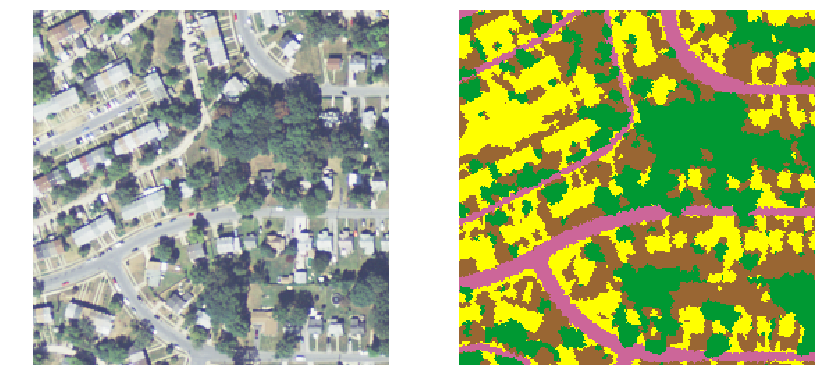

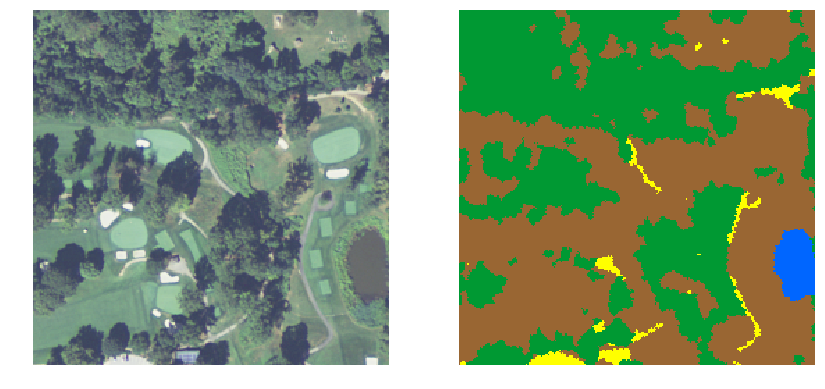

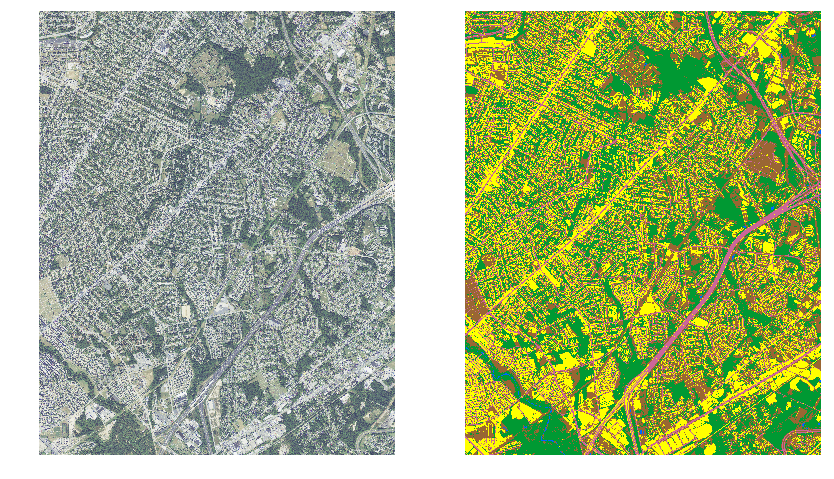

In [5]:
#load queries
tr = t_load(1,0,0,256)
disp_10(tr)
ts = t_load(2,0,0,256)
disp_10(ts)
tfull = t_load_full(1)
disp_10(tfull)

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/feature_extraction/image.py:287: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  indexing_strides = arr[slices].strides


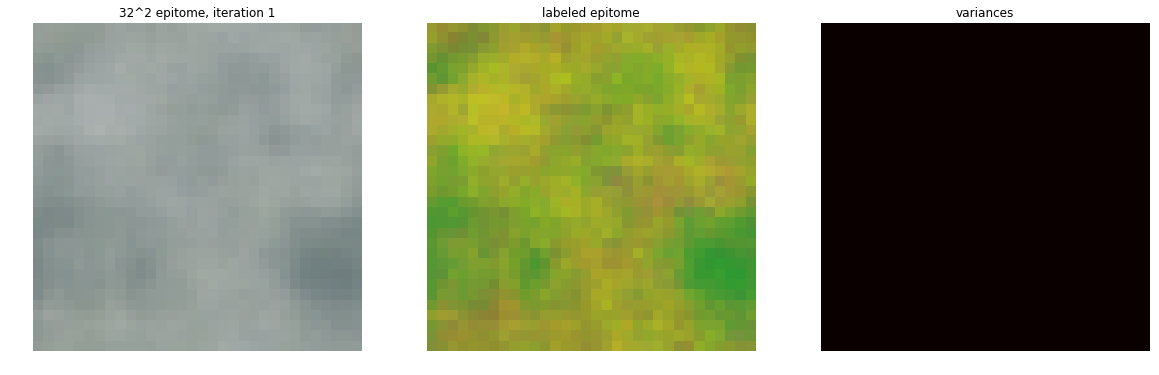

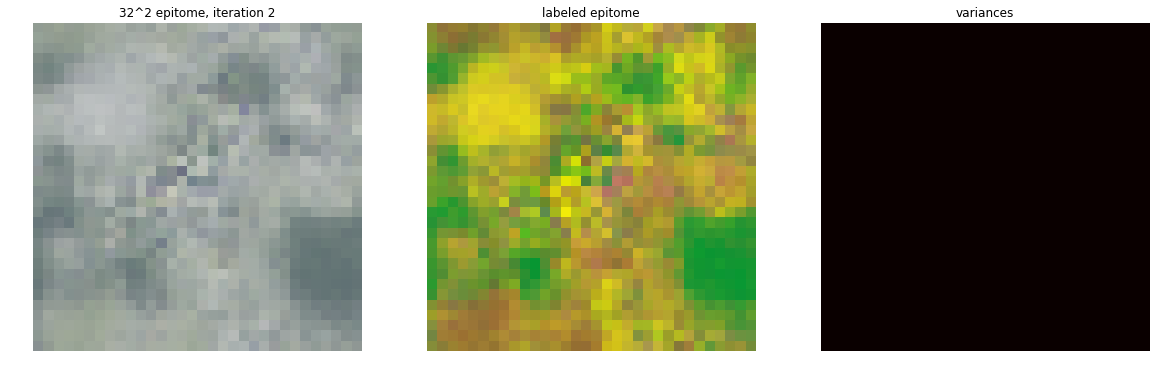

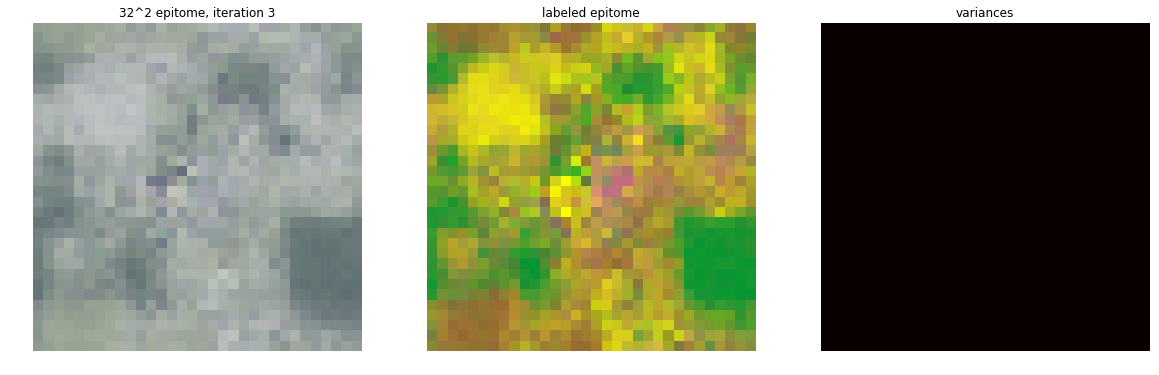

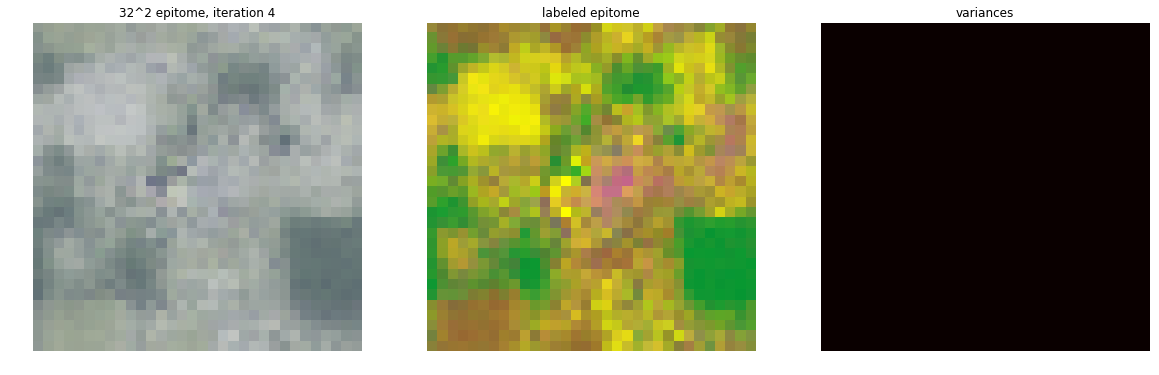

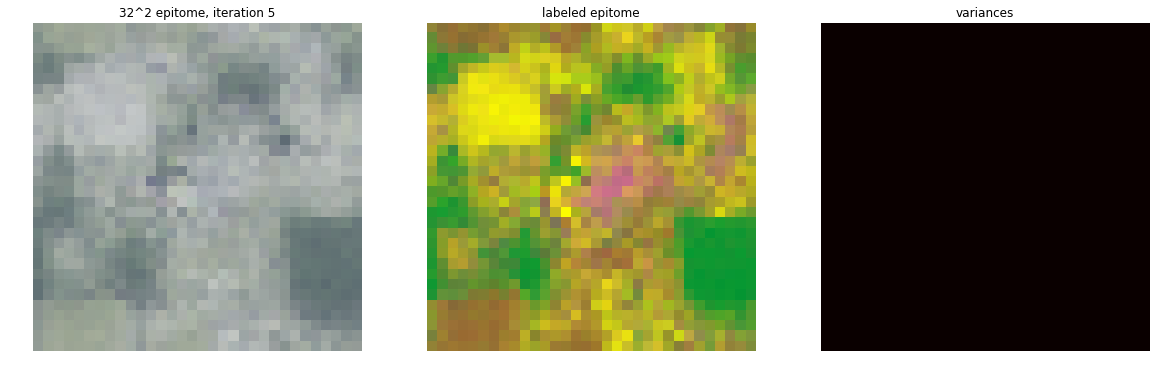

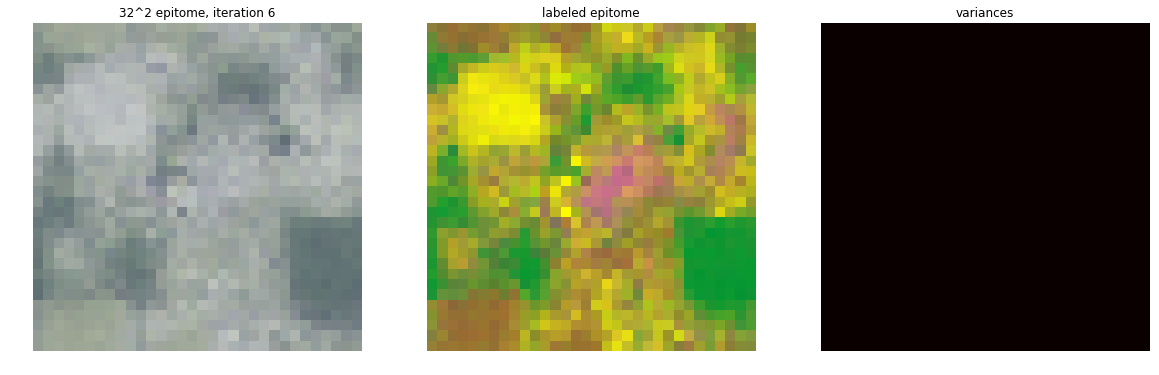

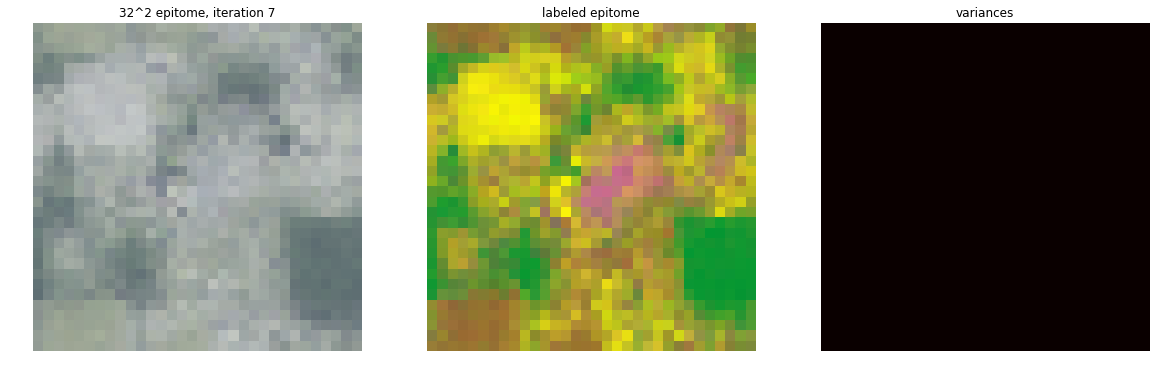

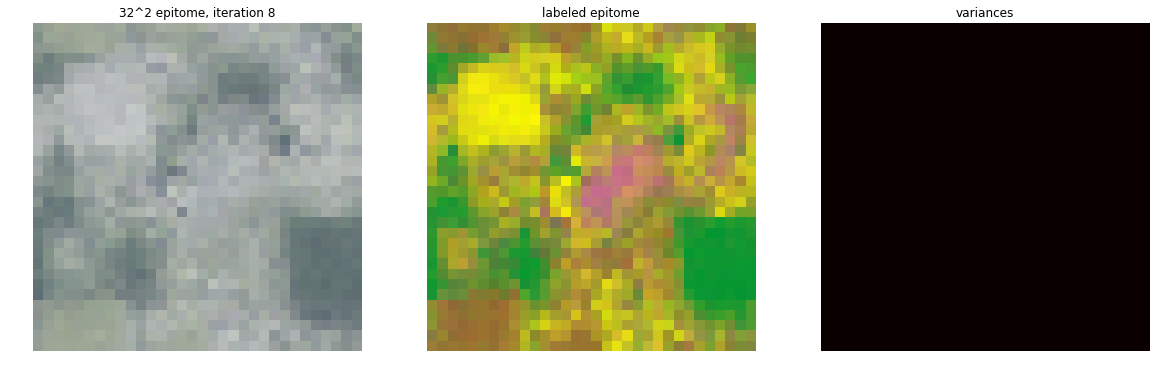

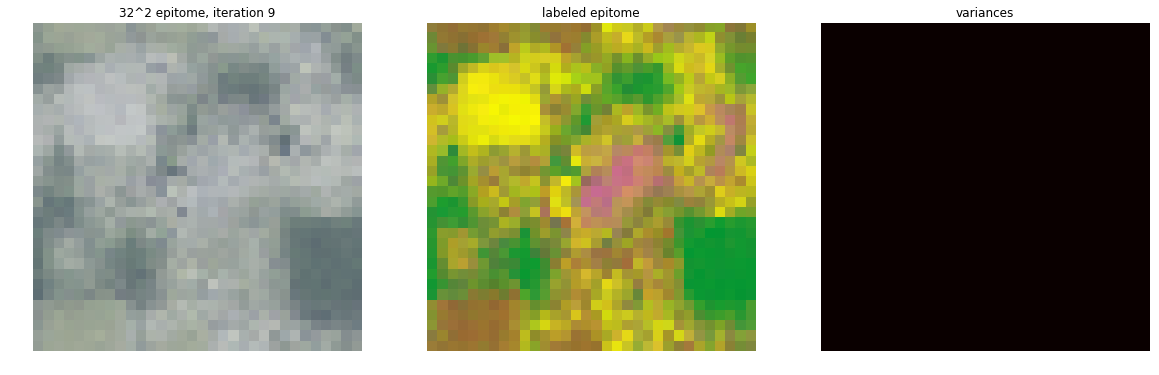

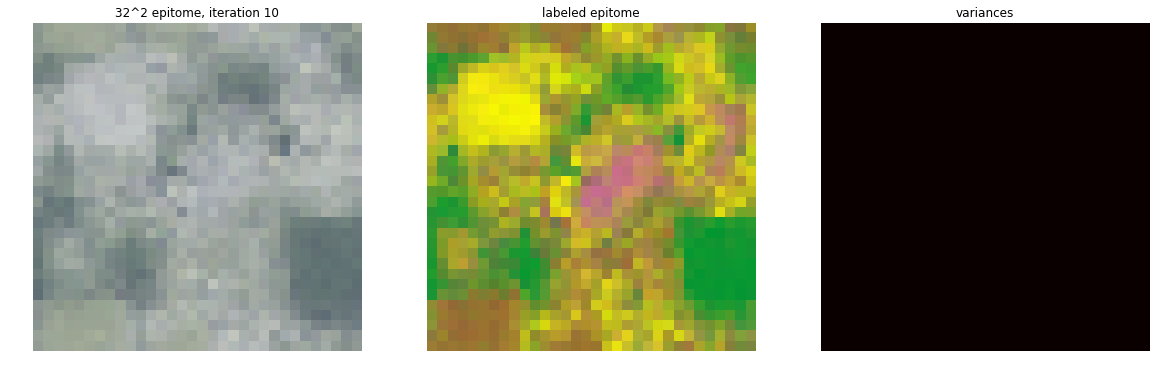

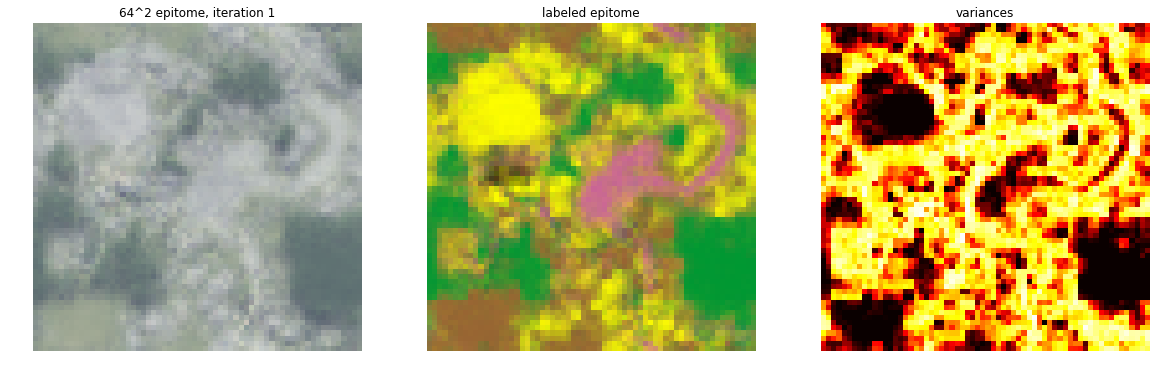

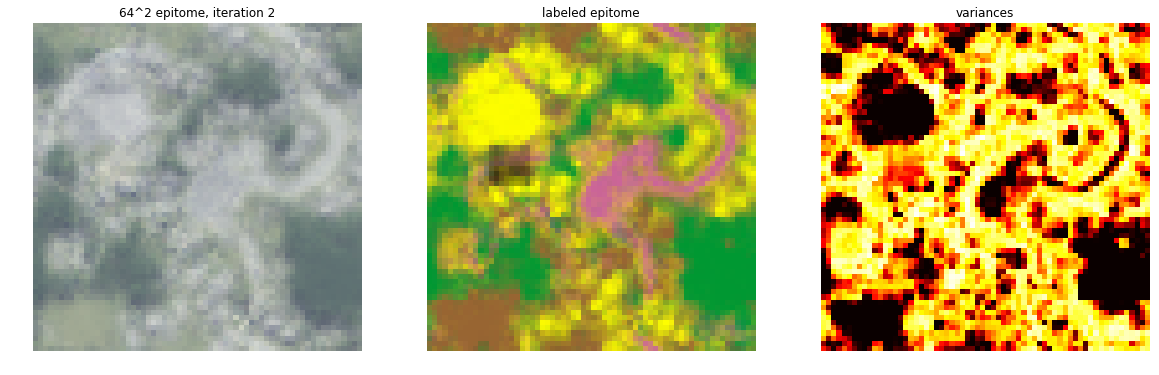

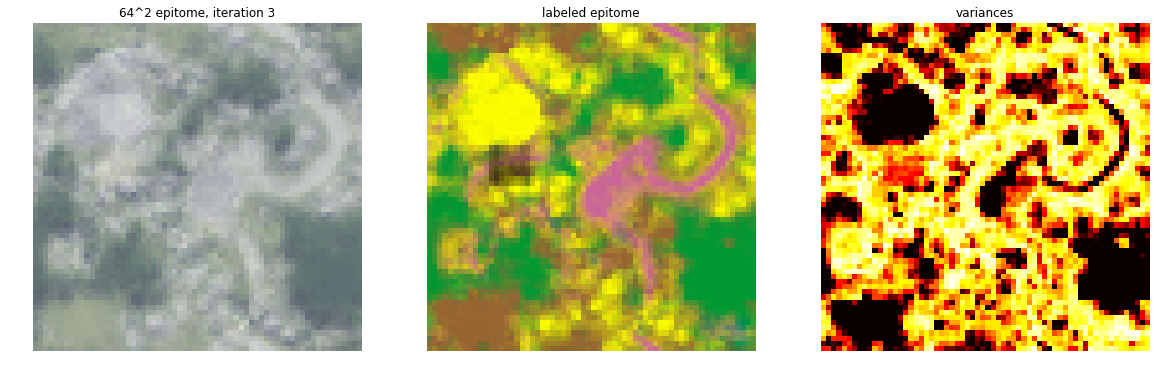

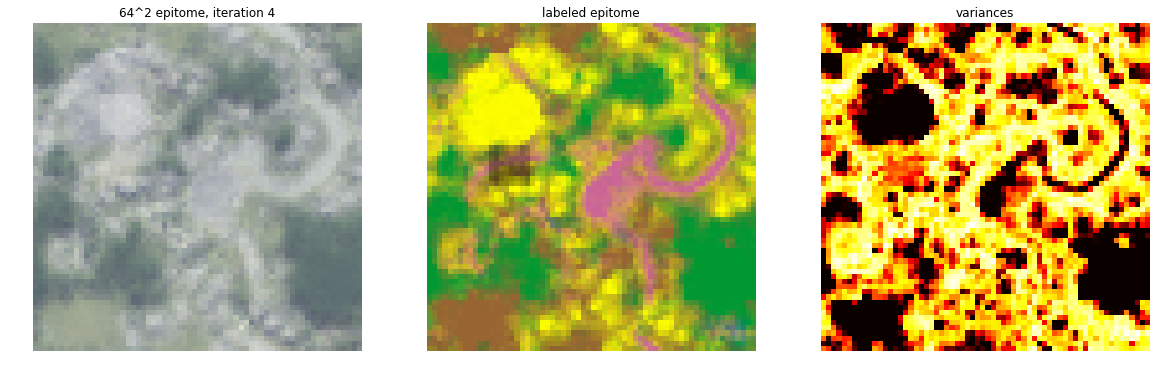

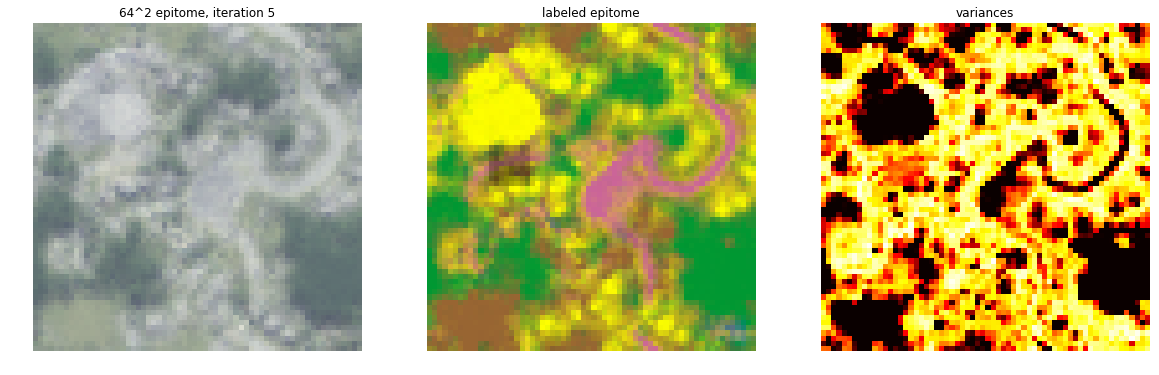

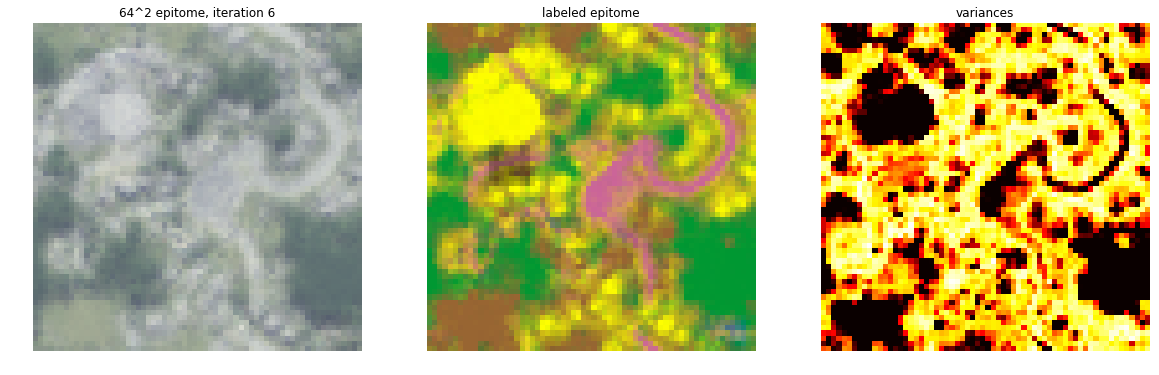

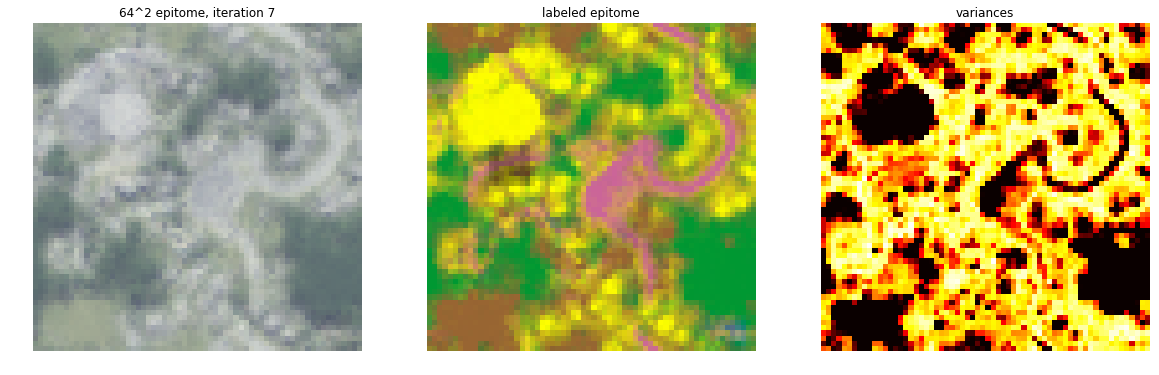

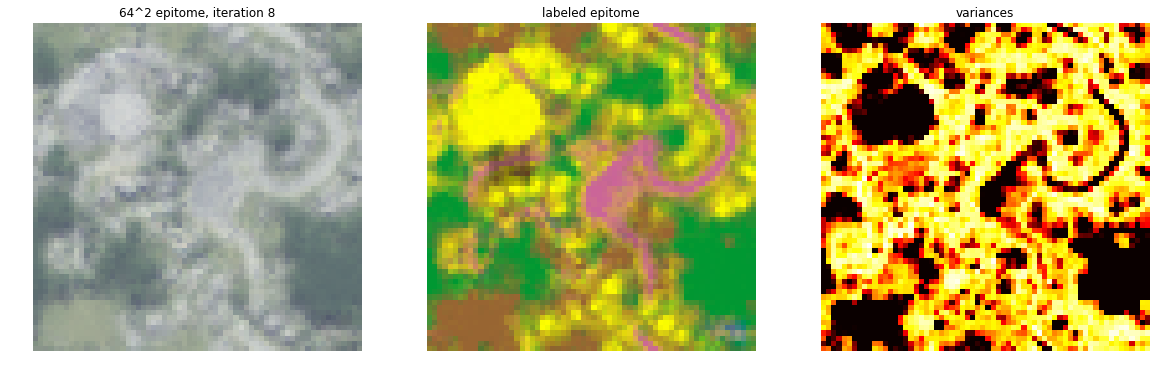

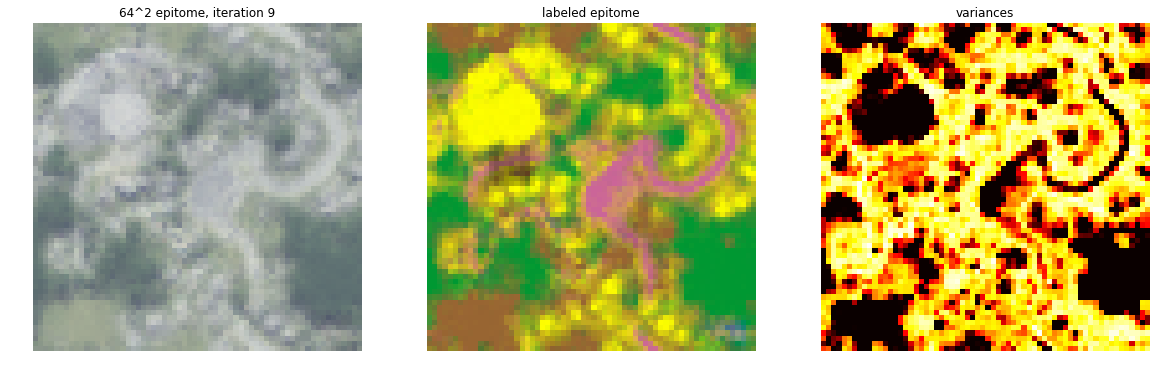

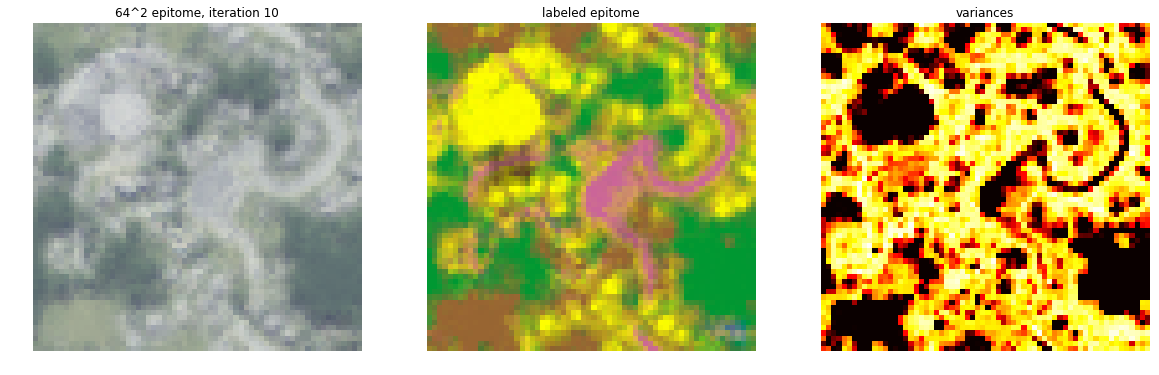

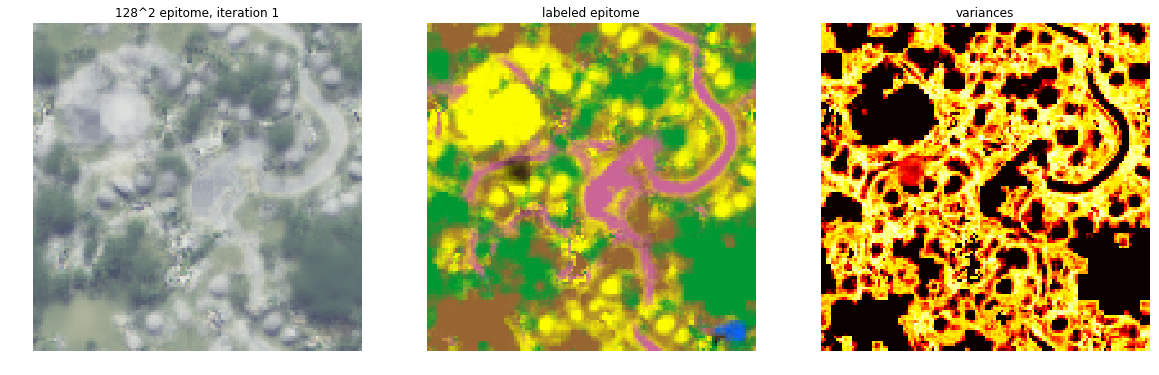

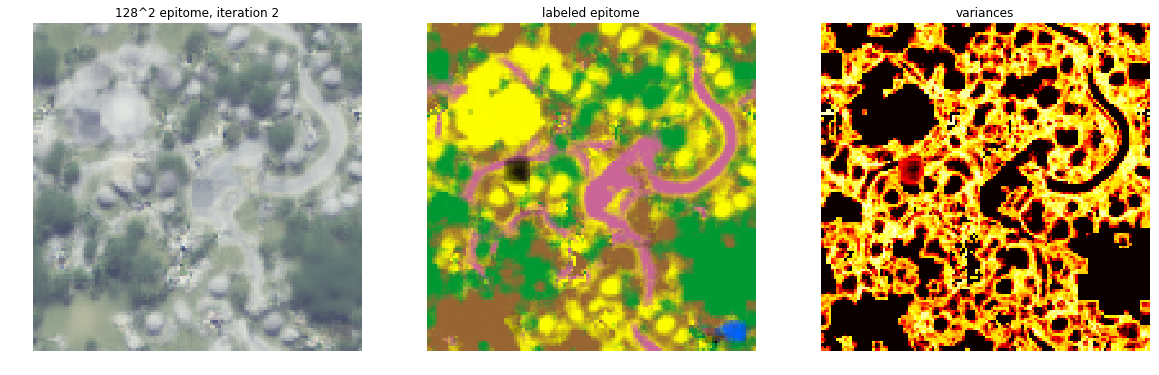

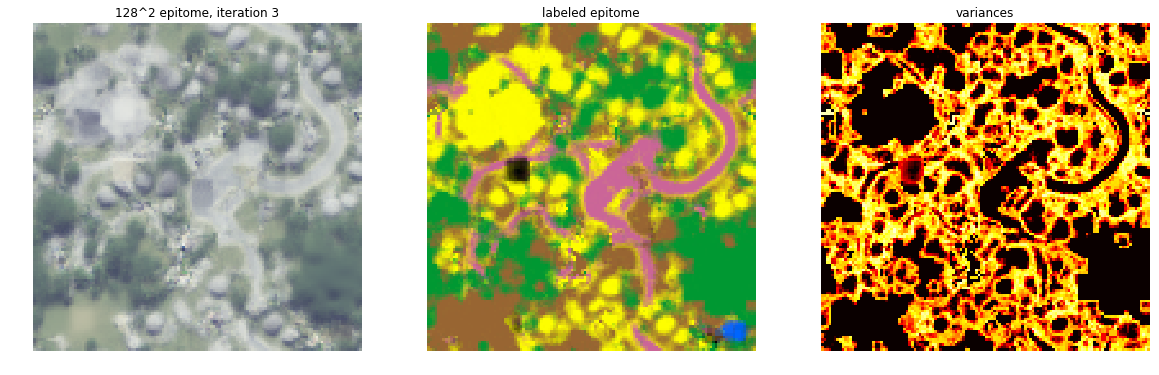

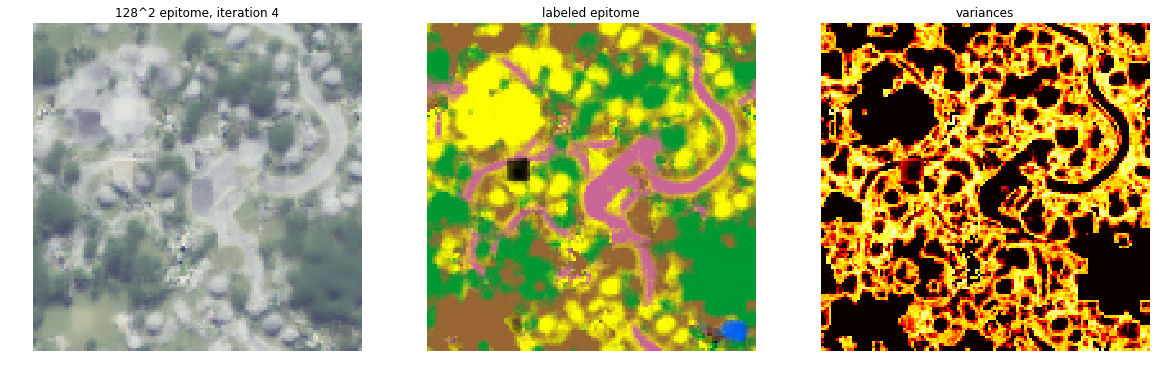

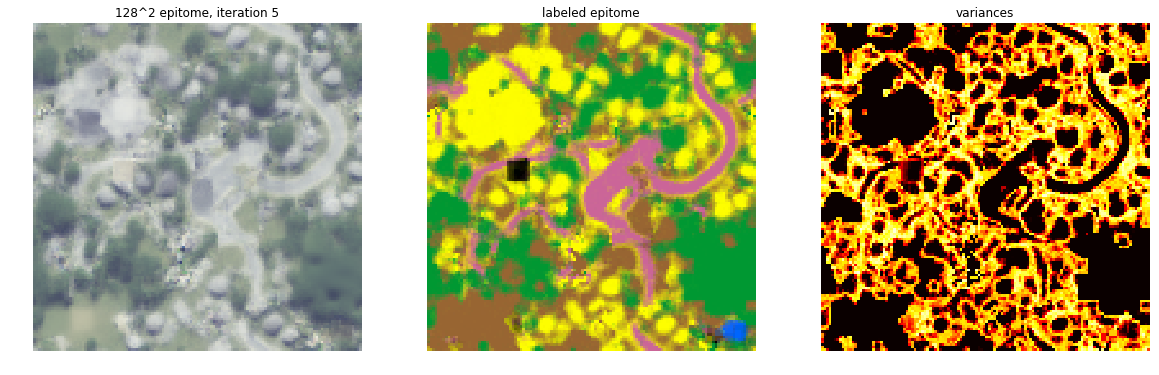

In [ ]:
#create epitome
#cProfile.run('e,ev,p,etr=epitome(trIMtorch,9,256,40000,10,[.125,.25,.5,1])',sort='cumtime')
cProfile.run('e,ev,p=epitome_noe(tfull,8,256,50000,10,[.125,.25,.5,1])',sort='cumtime')
torch.cuda.empty_cache()

In [ ]:
#reconstruct over a single epitome
cProfile.run('z=reconstruct(tr[:,:4,:,:],8,e[0,:4,:,:],ev[0,:4,:,:],e[0,4:,:,:],4)',sort='cumtime')
torch.cuda.empty_cache()

In [ ]:
#reconstruct over multiple epitomes
tempe = tr[0,:,:128,:128]
tempe2 = tr[0,:,128:,128:]
glom = torch.zeros((2,10,128,128)).to(device)
glom[0] = tempe
glom[1,:,:32,:32] = tempe2[:,:32,:32]
tempvar = torch.ones(2,4,128,128)/50
cProfile.run('z=reconstructplural(tr[:,:4,:,:],8,glom[:,:4,:,:],tempvar,glom[:,4:,:,:],8)',sort='cumtime')
torch.cuda.empty_cache()

In [ ]:
#display reconstruct output
#np.savez_compressed('reconstruction',a=z)
zmax = torch.argmax(z,dim=0)
z2 = z.permute(1,2,0)
labels = torch.matmul(z2,palette_torch)/256
fig=plt.figure(figsize=(21,14))
fig.add_subplot(131)
plt.axis('off')
plt.title('soft labels')
plt.imshow(labels)
fig.add_subplot(132)
plt.axis('off')
plt.title('argmax labels')
plt.imshow(palette_torch[zmax].int())
fig.add_subplot(133)
plt.axis('off')
plt.title('ground truth labels')
plt.imshow(palette_torch[get_labels(tr)].int())
plt.show()
plt.close()
error=zmax.cpu().numpy()-get_labels(tr)[:zmax.shape[0],:zmax.shape[1]]
print(torch.sum(error==0).float()/zmax.shape[0]**2)
plt.figure(figsize=(6,6))
temp = (error==0)
plt.imshow(temp,cmap='hot',interpolation='nearest')
plt.axis('off')
plt.show()
plt.close()

In [ ]:
#given a query, takes the top left corner as a synthetic epitome
#attempts to iteratively improve on the epitome by constructing a second epitome
#out of patches which the first epitome has the most errors (w.r.t the labels)
def learnnaive(p,esize,asize,rate):
    size = p.shape[2]
    glom = torch.zeros((2,10,esize,esize)).to(device)
    glom[0] = p[0,:,:esize,esize:]#unstable, careful
    step = esize//asize
    for i in range(step):
        for j in range(step):
            print(str(i)+' '+str(j))
            z = reconstructplural(p[:,:4,:,:],asize,glom[:,:4,:,:],torch.ones(2,4,128,128)/50,glom[:,4:,:,:],rate)
            torch.cuda.empty_cache()
            zmax = torch.argmax(z,dim=0)
            error = (zmax-get_labels(p)[:size,:size])==0
            cumerror = torch.squeeze(cum_sum(error.view(1,1,size,size),asize))
            #maximum error is where the fewest ==0
            maxerror = torch.argmin(cumerror)
            mi = maxerror//cumerror.shape[0]
            mj = maxerror%cumerror.shape[0]
            print(mi,mj,cumerror[mi,mj])
            #print(error[mi:mi+asize,mj:mj+asize])
            temp = p[0,:,mi:mi+asize,mj:mj+asize]
            #disp_10(torch.unsqueeze(temp,0))
            glom[1,:,i*asize:(i+1)*asize,j*asize:(j+1)*asize] = temp
            disp_10(glom[None,1])
    #torch.cuda.empty_cache()
    return glom

In [ ]:
#run and display learnnaive
cProfile.run('glom = learnnaive(tr,128,32,8)',sort='cumtime')
print(glom.shape)
z=reconstructplural(tr[:,:4,:,:],8,glom[:,:4,:,:],torch.ones(2,4,128,128)/50,glom[:,4:,:,:],2)
zmax = torch.argmax(z,dim=0)
z2 = z.permute(1,2,0)
labels = torch.matmul(z2,palette_torch)/256
fig=plt.figure(figsize=(21,14))
fig.add_subplot(131)
plt.axis('off')
plt.title('soft labels')
plt.imshow(labels)
fig.add_subplot(132)
plt.axis('off')
plt.title('argmax labels')
plt.imshow(palette_torch[zmax].int())
fig.add_subplot(133)
plt.axis('off')
plt.title('ground truth labels')
plt.imshow(palette_torch[get_labels(tr)].int())
plt.show()
plt.close()
error=zmax.cpu().numpy()-get_labels(tr)[:zmax.shape[0],:zmax.shape[1]]
print(torch.sum(error==0).float()/zmax.shape[0]**2)
plt.figure(figsize=(8,8))
temp = (error==0)
plt.imshow(temp,cmap='hot',interpolation='nearest')
plt.axis('off')
plt.show()
plt.close()
disp_10(glom)